# Network analysis workbook


[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/MNoichl/data-driven-philosophy-GAP2025/blob/main/workbook_02_network_analysis.ipynb) 

Welcome to google colab! Colab is a cloud-based notebook environment that allows you to write and execute code in the python programming language in the browser. It follows a notebook structure (like jupyter) in which you can write markdown text like this, as well as code in cells that can be executed.

Below is one of these cells. You can run it either by clicking the little (▶️) button on the top left of the cell, or by clicking into it and then pressing shift+enter:


In [1]:
print("Hello World")

Hello World


If you want to continue working on this notebook, and make your own changes to the code, we'd reccomend you save your own copy, by clicking the "File" menu at the top left, and then "Save a copy in Drive". Please do this as it's easy to loose your work otherwise. You can then edit your own copy. You can also download it as an .ipynb file by clicking the "File" menu at the top left, "Download", and then "Download .ipynb". If you want to learn more about the functionalites of colab notebooks, we reccommend looking at this [basic colab features-notebook.](https://colab.research.google.com/notebooks/basic_features_overview.ipynb)

# Part 1: Set-up
At the beginning of this notebook, we need to set up all of the libraries/packages (reusable python-programs other people have written) that we are going to use during this session. For this we use a common python-package manager called 'pip'. Pip takes care of downloading the right versions, and installing them on our computer, which in this case is a server that's standing in a google-data-center, maybe in Belgium or Iowa. These installs will take a minute or two.

In [2]:
!pip install pandas
!pip install pyalex
!pip install umap-learn
!pip install datamapplot
!pip install sentence-transformers
!pip install seaborn
!pip install genieclust
!pip install litellm
!pip install opinionated


# Check if utils directory exists, if not download from GitHub
import os
if not os.path.exists('utils'):
    !wget -q https://raw.githubusercontent.com/MNoichl/data-driven-philosophy-GAP2025/main/utils/openalex_utils.py -P utils/
    !wget -q https://raw.githubusercontent.com/MNoichl/data-driven-philosophy-GAP2025/main/utils/streamgraph.py -P utils/
    # Create __init__.py to make it a proper Python package
  #  !touch utils/__init__.py



# Part 2: Imports
After setting up the packages, we need to import them. This makes the code in the packages available for us to use later. 

In [39]:

# Our data-handling library:
import pandas as pd


# Our visualisation libraries:
import matplotlib.pyplot as plt
import seaborn as sns


# numerical calculations:
import numpy as np

# Interacting with the operating system:
import os

# Interacting with the OpenAlex API:
import pyalex

# Our network analysis library:
import networkx as nx



# Library for prettier graphics:
import opinionated
plt.style.use('opinionated_rc')
import colormaps as colormaps #https://pratiman-91.github.io/colormaps/
import random

import tqdm
from dataclasses import dataclass
from matplotlib.colors import Normalize



# Some utility functions for interacting with the OpenAlex API:
from utils.openalex_utils import openalex_url_to_pyalex_query, process_records_to_df, get_records_from_dois, openalex_url_to_filename, download_openalex_records

# Part 3: Getting data

To get our network-data, we are going to query the open-alex database. To make this easy,  we have written a function that takes in an arbitrary url to a OpenAlex search query, and downloads the abstracts associated with it. To use it, head over to [https://openalex.org](https://openalex.org), search for something you are interested in, and copy the web-address of your search address. Then replace the url behind ` openalex_url = `  with the new one. Make sure to keep the quotation marks around it. That tells python that this is a string of text, and not executable python code. 

In [4]:
openalex_url = 'https://openalex.org/works?page=1&filter=primary_location.source.id:s255146,publication_year:2005-2025'

dataset_df = download_openalex_records(openalex_url,
                                       reduce_sample=True, 
                                       sample_reduction_method="n random samples", 
                                       sample_size=5000, 
                                       seed_value="42")


dataset_df['text'] = dataset_df['title'] + dataset_df['abstract'] 
# We filter for works that have an abstract:
dataset_df = dataset_df[dataset_df['text'].str.len() > 10]

text_data = list(dataset_df['text'])
year_data = dataset_df['publication_year']
title_data = dataset_df['title']

used_dataset = "OpenAlex-query"






Input: https://openalex.org/works?page=1&filter=primary_location.source.id:s255146,publication_year:2005-2025
Starting data retrieval pipeline
Filename: primary_location_source_id_s255146__publication_year_2005-2025__20251016_232537
Requesting 6813 entries from query 1/1 (expecting to download 5000)...
Attempting PyAlex sampling: 5000 from 6813 (seed=42)
PyAlex sampling successful: got 5000 records (requested 5000)
Query completed in 40.34 seconds
Total records collected: 5000
Expected to download: 5000
Available from all queries: 6813
Sample method used: n random samples
Reduce sample enabled: True
Seed value: 42


We can take a look at the data, by displaying the dataframe-object:

In [5]:
display(dataset_df)

,id,doi,title,display_name,relevance_score,publication_year,publication_date,ids,language,primary_location,...,abstract_inverted_index,cited_by_api_url,counts_by_year,updated_date,created_date,fulltext_origin,abstract,parsed_publication,query_index,text
0,https://openalex.org/W3198427034,https://doi.org/10.1007/s11229-021-03407-x,Long-arm functional individuation of computation,Long-arm functional individuation of computation,0.999955,2021,2021-11-01,{'openalex': 'https://openalex.org/W3198427034...,en,"{'is_oa': True, 'landing_page_url': 'https://d...",...,"{'Abstract': [0], 'A': [1, 133], 'single': [2]...",https://api.openalex.org/works?filter=cites:W3...,"[{'year': 2024, 'cited_by_count': 2}, {'year':...",2025-10-16T01:26:47.925518,2021-09-13,NaN,Abstract A single physical process may often b...,Synthese,0,Long-arm functional individuation of computati...
1,https://openalex.org/W4404640700,https://doi.org/10.1007/s11229-024-04819-1,The reasonableness of doubt: phenomenology and...,The reasonableness of doubt: phenomenology and...,0.999935,2024,2024-11-22,{'openalex': 'https://openalex.org/W4404640700...,en,"{'is_oa': False, 'landing_page_url': 'https://...",...,None,https://api.openalex.org/works?filter=cites:W4...,[],2025-09-28T15:57:52.746896,2024-11-23,NaN,,Synthese,0,The reasonableness of doubt: phenomenology and...
2,https://openalex.org/W2097655064,https://doi.org/10.1007/s11229-010-9857-5,All things considered duties to believe,All things considered duties to believe,0.999868,2010,2010-12-14,{'openalex': 'https://openalex.org/W2097655064...,en,"{'is_oa': True, 'landing_page_url': 'https://d...",...,"{'To': [0], 'be': [1], 'a': [2, 12, 96, 115], ...",https://api.openalex.org/works?filter=cites:W2...,"[{'year': 2023, 'cited_by_count': 2}, {'year':...",2025-10-08T02:47:22.626488,2016-06-24,pdf,To be a doxastic deontologist is to claim that...,Synthese,0,All things considered duties to believeTo be a...
3,https://openalex.org/W2115226938,https://doi.org/10.1007/s11229-010-9723-5,Downward causation without foundations,Downward causation without foundations,0.999792,2010,2010-02-26,{'openalex': 'https://openalex.org/W2115226938...,en,"{'is_oa': False, 'landing_page_url': 'https://...",...,None,https://api.openalex.org/works?filter=cites:W2...,"[{'year': 2025, 'cited_by_count': 2}, {'year':...",2025-09-17T11:42:41.489684,2016-06-24,ngrams,,Synthese,0,Downward causation without foundations
4,https://openalex.org/W4365446674,https://doi.org/10.1007/s11229-023-04106-5,When Arne met J. L.: attitudes to scientific m...,When Arne met J. L.: attitudes to scientific m...,0.999622,2023,2023-04-13,{'openalex': 'https://openalex.org/W4365446674...,en,"{'is_oa': True, 'landing_page_url': 'https://d...",...,"{'Abstract': [0], 'In': [1], 'the': [2, 18, 37...",https://api.openalex.org/works?filter=cites:W4...,"[{'year': 2025, 'cited_by_count': 1}, {'year':...",2025-10-07T22:12:27.905386,2023-04-15,pdf,"Abstract In the autumn of 1959, Arne Naess and...",Synthese,0,When Arne met J. L.: attitudes to scientific m...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,https://openalex.org/W3021529288,https://doi.org/10.1007/s11229-020-02675-3,Endogenous epistemic factionalization,Endogenous epistemic factionalization,0.267585,2020,2020-06-04,{'openalex': 'https://openalex.org/W3021529288...,en,"{'is_oa': False, 'landing_page_url': 'https://...",...,None,https://api.openalex.org/works?filter=cites:W3...,"[{'year': 2025, 'cited_by_count': 4}, {'year':...",2025-10-09T00:27:36.390893,2020-05-13,NaN,,Synthese,0,Endogenous epistemic factionalization
4996,https://openalex.org/W2183496132,https://doi.org/10.1007/s11229-015-0889-8,Visual experience: rich but impenetrable,Visual experience: rich but impenetrable,0.267344,2015,2015-09-08,{'openalex': 'https://openalex.org/W2183496132...,en,"{'is_oa': False, 'landing_page_url': 'https://...",...,None,https://api.openalex.org/works?filter=cites:W2...,"[{'year': 2025

One column is particularly interesting to us, `referenced_works`, which contains lists with ids for the cited articles:

In [6]:
dataset_df['referenced_works']

0       [https://openalex.org/W1533908468, https://ope...
1       [https://openalex.org/W126720719, https://open...
2       [https://openalex.org/W1649717260, https://ope...
3       [https://openalex.org/W1493532058, https://ope...
4       [https://openalex.org/W1592223710, https://ope...
                              ...                        
4995    [https://openalex.org/W1492301466, https://ope...
4996    [https://openalex.org/W1524143658, https://ope...
4997    [https://openalex.org/W1510271585, https://ope...
4998    [https://openalex.org/W1532481617, https://ope...
4999    [https://openalex.org/W145032598, https://open...
Name: referenced_works, Length: 4984, dtype: object

# Part 4: Constructing a network

There are many ways to build networks from bibliometric data. The most common ones are co-citation-networks (nodes get linked, if they get cited together), bibliometric coupling (nodes get links if they cite the same thing), as well as co-authorship networks. They also differ in what nodes represent - articles, authors, journals, instiutions, etc. In our case we are building an author based, internal co-citation-network.

In [ ]:
from itertools import combinations

# Create an undirected graph for author co-citation network
G = nx.Graph()

# First, collect all authors and their papers
author_to_papers = {}
paper_to_authors = {}

# Extract authors from each paper
for idx, row in dataset_df.iterrows():
    paper_id = row['id']
    
    # Get authors for this paper
    if 'authorships' in row and row['authorships'] is not None:
        authors = []
        authorships = row['authorships']
        
        # Handle different formats of authorships
        if isinstance(authorships, list):
            for authorship in authorships:
                if isinstance(authorship, dict) and 'author' in authorship:
                    author_info = authorship['author']
                    if isinstance(author_info, dict) and 'id' in author_info:
                        author_id = author_info['id']
                        author_name = author_info.get('display_name', author_id)
                        authors.append((author_id, author_name))
        
        # Store author-paper relationships
        if authors:
            paper_to_authors[paper_id] = authors
            for author_id, author_name in authors:
                if author_id not in author_to_papers:
                    author_to_papers[author_id] = []
                author_to_papers[author_id].append(paper_id)

# Add author nodes to the graph
for author_id, papers in author_to_papers.items():
    # Get author name from the first paper
    author_name = author_id
    for paper_id in papers:
        if paper_id in paper_to_authors:
            for aid, aname in paper_to_authors[paper_id]:
                if aid == author_id:
                    author_name = aname
                    break
            break
    
    G.add_node(author_id, 
               name=author_name,
               paper_count=len(papers))

# Create co-citation edges (excluding coauthorship-only pairs)
cocitation_count = 0
for idx, row in dataset_df.iterrows():
    citing_paper = row['id']
    
    # Get the referenced works (citations) for this paper
    if 'referenced_works' in row and row['referenced_works'] is not None and len(row['referenced_works']) > 0:
        referenced_works = row['referenced_works']
        
        # Handle different formats of referenced_works
        if isinstance(referenced_works, str):
            try:
                referenced_works = referenced_works.strip('[]').split(',')
                referenced_works = [ref.strip().strip("'\"") for ref in referenced_works if ref.strip()]
            except:
                referenced_works = []
        elif isinstance(referenced_works, list):
            pass
        else:
            referenced_works = []
        
        # Map each referenced work to its authors (within our dataset)
        work_to_authors = {
            cp: [aid for aid, _ in paper_to_authors[cp]]
            for cp in referenced_works if cp in paper_to_authors
        }
        
        # Count each author pair at most once per citing paper
        pairs_this_citing = set()
        for w1, w2 in combinations(work_to_authors.keys(), 2):
            for a1 in work_to_authors[w1]:
                for a2 in work_to_authors[w2]:
                    if a1 != a2:
                        pairs_this_citing.add(tuple(sorted((a1, a2))))
        
        for a1, a2 in pairs_this_citing:
            if a1 in G.nodes() and a2 in G.nodes():
                if G.has_edge(a1, a2):
                    G[a1][a2]['weight'] += 1
                else:
                    G.add_edge(a1, a2, weight=1)
                cocitation_count += 1
G.remove_edges_from(nx.selfloop_edges(G))

print(f"Author co-citation network created with {G.number_of_nodes()} nodes and {G.number_of_edges()} edges")
print(f"Total co-citation relationships: {cocitation_count}")

# Display basic network statistics
print(f"\nNetwork Statistics:")
print(f"- Nodes (authors): {G.number_of_nodes()}")
print(f"- Edges (co-citations): {G.number_of_edges()}")
print(f"- Density: {nx.density(G):.4f}")
print(f"- Is connected: {nx.is_connected(G)}")

if G.number_of_edges() > 0:
    print(f"- Average degree: {sum(dict(G.degree()).values()) / G.number_of_nodes():.2f}")
    
    # Show top co-cited author pairs
    edge_weights = [(G[u][v]['weight'], u, v) for u, v in G.edges()]
    edge_weights.sort(reverse=True)
    print(f"\nTop 5 co-cited author pairs:")
    for i, (weight, author1, author2) in enumerate(edge_weights[:5]):
        name1 = G.nodes[author1].get('name', author1)
        name2 = G.nodes[author2].get('name', author2)
        print(f"  {i+1}. {name1} & {name2} (co-cited {weight} times)")


Author co-citation network created with 4720 nodes and 6591 edges
Total co-citation relationships: 7818

Network Statistics:
- Nodes (authors): 4720
- Edges (co-citations): 6591
- Density: 0.0006
- Is connected: False
- Average degree: 2.79

Top 5 co-cited author pairs:
  1. Carl F. Craver & David M. Kaplan (co-cited 14 times)
  2. Gualtiero Piccinini & Carl F. Craver (co-cited 13 times)
  3. Oron Shagrir & Carl F. Craver (co-cited 12 times)
  4. Oron Shagrir & Gualtiero Piccinini (co-cited 11 times)
  5. Gualtiero Piccinini & David M. Kaplan (co-cited 10 times)


In our case, we will focus only on the largest connected part of the network (the 'giant component').

In [15]:
if nx.is_directed(G):
    largest_cc = max(nx.weakly_connected_components(G), key=len)
else:
    largest_cc = max(nx.connected_components(G), key=len)
G_giant_component = G.subgraph(largest_cc).copy()





# Part 5: Community detection 

To get a hold on the structure of a network, we can apply community detection (basically clustering for networks) to it. One classic algorithm for this is the Louvain-Algorithm.

In [ ]:
from networkx.algorithms.community import louvain_communities

print("Detecting communities using Louvain algorithm...")
communities = louvain_communities(G_giant_component, 
                                weight='weight', 
                                resolution=1.0, 
                                seed=42)

print(f"Found {len(communities)} communities")

# Create a dictionary mapping nodes to community IDs
node_to_community = {}
for i, community in enumerate(communities):
    for node in community:
        node_to_community[node] = i

# Add community information to nodes
nx.set_node_attributes(G_giant_component, node_to_community, 'community')

# Display community statistics
community_sizes = [len(community) for community in communities]
print(f"\nCommunity Statistics:")
print(f"- Number of communities: {len(communities)}")
print(f"- Largest community size: {max(community_sizes)}")
print(f"- Smallest community size: {min(community_sizes)}")
print(f"- Average community size: {sum(community_sizes) / len(community_sizes):.2f}")

# Show top 5 largest communities
sorted_communities = sorted(enumerate(communities), key=lambda x: len(x[1]), reverse=True)
print(f"\nTop 5 largest communities:")
for i, (comm_id, community) in enumerate(sorted_communities[:5]):
    print(f"  Community {comm_id}: {len(community)} authors")
    # Show a few example authors from each community
    sample_authors = list(community)[:3]
    author_names = [G_giant_component.nodes[author].get('name', author) for author in sample_authors]
    print(f"    Examples: {', '.join(author_names)}")
    if len(community) > 3:
        print(f"    ... and {len(community) - 3} more")


Detecting communities using Louvain algorithm...
Found 21 communities

Community Statistics:
- Number of communities: 21
- Largest community size: 149
- Smallest community size: 4
- Average community size: 64.81

Top 5 largest communities:
  Community 12: 149 authors
    Examples: Benjamin McMyler, Michael Thicke, Carlos Santana
    ... and 146 more
  Community 6: 147 authors
    Examples: Daniel Giberman, Fabrice Pataut, Gabriele Contessa
    ... and 144 more
  Community 4: 137 authors
    Examples: Alison Springle, Marko Jurjako, Juan Pablo Bermúdez
    ... and 134 more
  Community 9: 94 authors
    Examples: Ilmari Hirvonen, Ernest W. Adams, Marion Durand
    ... and 91 more
  Community 16: 91 authors
    Examples: Daniel R. Williams, J. Brendan Ritchie, Mark Povich
    ... and 88 more


# Part 6: Visualization

Finally, we can use a force directed simulation to visualize our network. Here we use ForceAtlas2.

Computing ForceAtlas2 layout...
Plotting the network...


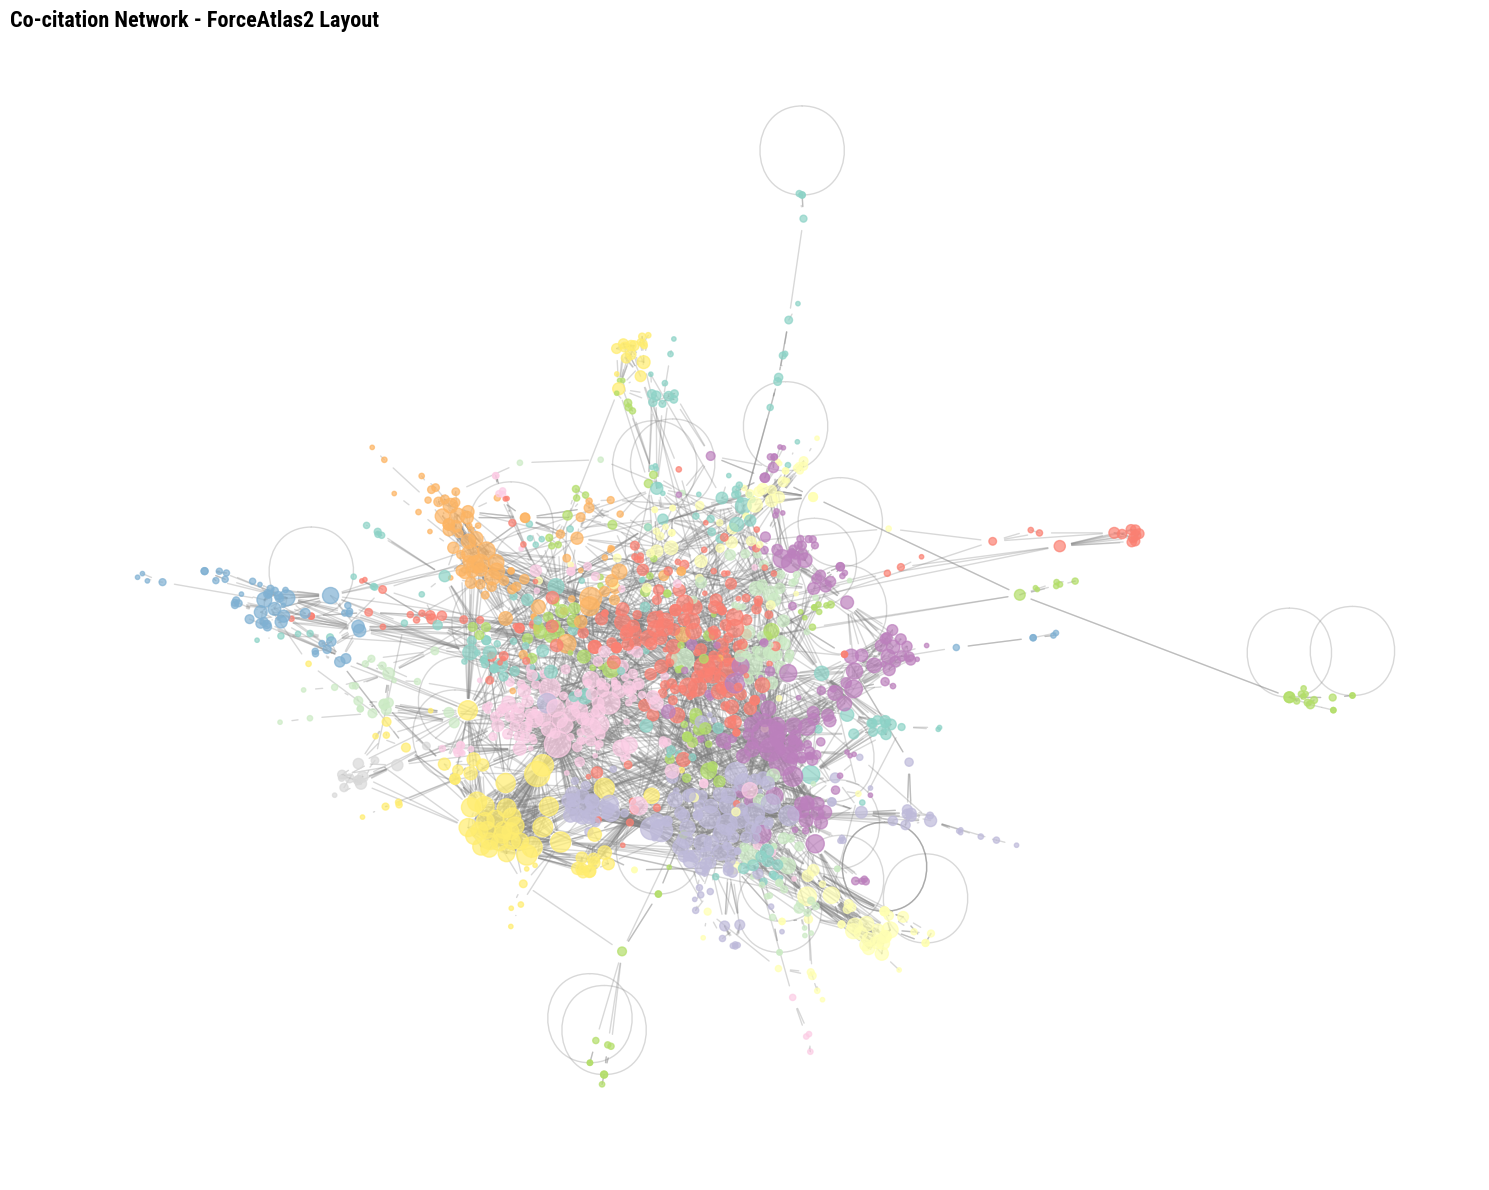

ForceAtlas2 layout completed for 40 nodes and 780 edges


In [ ]:
# ForceAtlas2 layout and visualization using NetworkX
import matplotlib.pyplot as plt



node_degrees = dict(G_giant_component.degree())

    # Use NetworkX ForceAtlas2 layout
print("Computing ForceAtlas2 layout...")
positions = nx.forceatlas2_layout(G_giant_component, 
                                    max_iter=500,  # Number of iterations
                                    jitter_tolerance=1.0,  # Tolerance for speed adjustment
                                    scaling_ratio=2.,  # Scaling of forces
                                    gravity=5,  # Attraction to center
                                    distributed_action=False,  # Distribute attraction force
                                    node_size = {n: np.log(d+1) * 2 for n, d in G_giant_component.degree()},
                                    strong_gravity=False,  # Strong gravitational pull
                                    weight='weight',  # Edge weight attribute
                                    dissuade_hubs=True,  # Prevent hub clustering
                                    linlog=False,  # Use linear attraction
                                    seed=42,  # Random seed for reproducibility
                                    dim=2)  # 2D layout


print('Plotting the network...')
# Create the plot
plt.figure(figsize=(15, 12))

# Draw the network
# Scale node sizes by degree

# Add positions as node attributes
for node, (x, y) in positions.items():
    G_giant_component.nodes[node]['x'] = x
    G_giant_component.nodes[node]['y'] = y

node_sizes = [node_degrees[node] * 5 + 5 for node in G_giant_component.nodes()]

# Color nodes by community
node_colors = [node[1]['community'] for node in G_giant_component.nodes(data=True)]

nx.draw_networkx_nodes(G_giant_component, positions, 
                      node_size=node_sizes, 
                      node_color=node_colors, 
                      cmap=plt.cm.Set3,
                      alpha=0.7)

nx.draw_networkx_edges(G_giant_component, positions, 
                      edge_color='gray', 
                      alpha=0.3, 
                      arrows=True, 
                      arrowsize=10,
                      arrowstyle='-')

plt.title("Co-citation Network - ForceAtlas2 Layout", fontsize=16)
plt.axis('off')
plt.tight_layout()
plt.show()

print(f"ForceAtlas2 layout completed for {G_giant_component.number_of_nodes()} nodes and {G_giant_component.number_of_edges()} edges")


# Part 7: Pagerank 
We can also compute statistics on individual nodes. One classic one is googles' page-rank algorithm, which basically computes how likely it is for a random walk over the graph, going from each node via to the next randomly chosen connected one, to end up at a specific. Nodes that have a high pagerank are not just only linked to a lot of other nodes, but are particularily well linked to nodes that are very central to the network itself: An indication of particular influence in the network.

In [18]:
# Compute PageRank on the network
print("Computing PageRank...")
pagerank_scores = nx.pagerank(G, weight='weight', alpha=0.85, max_iter=100, tol=1e-06)

# Get top 10 nodes by PageRank score
top_10_pagerank = sorted(pagerank_scores.items(), key=lambda x: x[1], reverse=True)[:10]

print("\nTop 10 nodes by PageRank score:")
print("=" * 50)
for i, (node_id, score) in enumerate(top_10_pagerank, 1):
    # Get node name if available
    node_name = G.nodes[node_id].get('name', 'Unknown')
    print(f"{i:2d}. {node_name}")
    print(f"    ID: {node_id}")
    print(f"    PageRank: {score:.6f}")
    print(f"    Degree: {G.degree(node_id)}")
    print()


Computing PageRank...

Top 10 nodes by PageRank score:
 1. Carl F. Craver
    ID: https://openalex.org/A5045269466
    PageRank: 0.006018
    Degree: 110

 2. Gualtiero Piccinini
    ID: https://openalex.org/A5042488865
    PageRank: 0.003906
    Degree: 78

 3. Duncan Pritchard
    ID: https://openalex.org/A5082884079
    PageRank: 0.003221
    Degree: 71

 4. Oron Shagrir
    ID: https://openalex.org/A5078729656
    PageRank: 0.002880
    Degree: 54

 5. Christoph Kelp
    ID: https://openalex.org/A5055212668
    PageRank: 0.002577
    Degree: 51

 6. Kristie Miller
    ID: https://openalex.org/A5070749405
    PageRank: 0.002351
    Degree: 36

 7. Paweł Gładziejewski
    ID: https://openalex.org/A5021835319
    PageRank: 0.002347
    Degree: 44

 8. Karl Friston
    ID: https://openalex.org/A5086852785
    PageRank: 0.002330
    Degree: 51

 9. Jakob Hohwy
    ID: https://openalex.org/A5083789193
    PageRank: 0.002268
    Degree: 49

10. Cyrille Imbert
    ID: https://openalex.org/

# Part 8: A short ABM

For practice, we can implement a version of a classic Agent-Based model, the Hegselmann-Krause [model of opinion dynamics](https://www.jasss.org/5/3/2/2.pdf). But we add a twist to it, by running it on our network from above! First, we implement an agent-class. Each agent will be assigned a node id in ou network, as well as an opinion, and an update function. Agents update their opinions in each step to the average of all the opinions (including their own current one) of the nodes they can see in the network, and which have opinions within the range $\epsilon$. The idea is: We are willing to adapt our opinions to those of our neighbours, unless they are radically different to our own, in which case they leave us untouched.

In [ ]:

@dataclass
class Agent:
    node: int
    opinion: float  # keep in [0, 1]
    
        # Get i's current opinion
    def update(self, G, agents, epsilon):
        """Update this agent's opinion based on neighbors within epsilon distance."""
        # Get all neighbors of this agent
        neighbors = list(G.neighbors(self.node))
        
        # Build confidence set: include self and neighbors within epsilon distance
        confidence_set = [self.opinion]  # Always include self
        
        for neighbor in neighbors:
            neighbor_opinion = agents[neighbor].opinion
            if abs(self.opinion - neighbor_opinion) <= epsilon:
                confidence_set.append(neighbor_opinion)
        
        # Update opinion to the average of the confidence set
        self.opinion = sum(confidence_set) / len(confidence_set)


Now we set up our model. The main components are: 1. the init-function, which sets up an agent for each node we pass to the network with a randomly initialized opinion between 0 and 1, as well as the global parameter $\epsilon$. 2. The step function, which updates all agents in random order. 3. A plotting function, that plots the current state of the model when we call it. 

In [61]:
class HKModel:
    def __init__(self, G: nx.Graph, epsilon: float, opinions=None, seed: int | None = None):
        """
        G: a NetworkX graph
        epsilon: global confidence bound
        opinions: None for random in [0,1], or dict {node: opinion} or array-like in node order
        """
        self.G = G.copy()
        self.epsilon = float(epsilon)
        self.rng = random.Random(seed)
        self.current_step = 0
        np_rng = np.random.default_rng(seed)

        nodes = list(self.G.nodes())
        if opinions is None:
            init = {n: float(np_rng.random()) for n in nodes}
        elif isinstance(opinions, dict): 
            init = {n: float(opinions[n]) for n in nodes}
        else:
            arr = np.asarray(opinions, dtype=float)
            if len(arr) != len(nodes):
                raise ValueError("opinions vector length must match number of nodes")
            init = {n: float(x) for n, x in zip(nodes, arr)}

        self.agents: dict[int, Agent] = {n: Agent(n, np.clip(init[n], 0.0, 1.0)) for n in nodes}

        # cache node list for fast sampling
        self._nodes = list(self.G.nodes())
        if len(self._nodes) == 0:
            raise ValueError("Graph has no nodes.")

    def step(self):
        """Do 1 step. Each step updates all agents in random order."""

        nodes_shuffled = self._nodes.copy()
        self.rng.shuffle(nodes_shuffled)
        
        # Update each agent in random order
        for i in nodes_shuffled:
            self.agents[i].update(self.G, self.agents, self.epsilon)
        self.current_step += 1

    def opinions_dict(self) -> dict:
        return {n: self.agents[n].opinion for n in self.G.nodes()}

    def opinions_array(self) -> np.ndarray:
        return np.array([self.agents[n].opinion for n in self.G.nodes()], dtype=float)

    def plot(self, with_labels=False, title=None, cmap=plt.cm.viridis):
        """
        Plot the network with node colors given by opinions in [0,1].
        If nodes have an 'xy' attribute, use it. Else use spring_layout.
        Includes a histogram facet showing the distribution of opinions.
        """
        created_fig = False
        fig, (ax, hist_ax) = plt.subplots(2, 1, figsize=(6, 8), height_ratios=[1, 0.3])
        created_fig = True

        # positions
        nodes = list(self.G.nodes())
        if nodes and "x" in self.G.nodes[nodes[0]]:
            pos = {n: (self.G.nodes[n]["x"], self.G.nodes[n]["y"]) for n in nodes}
        else:
            print("Computing spring layout")
            pos = nx.spring_layout(self.G, seed=123, iterations=1000)
            for n in nodes:
                self.G.nodes[n]["x"] = pos[n][0]
                self.G.nodes[n]["y"] = pos[n][1]

        opinions = self.opinions_array()
        norm = Normalize(vmin=0.0, vmax=1.0)

        # draw network
        nx.draw_networkx_edges(self.G, pos, ax=ax, alpha=0.4)
        sc = nx.draw_networkx_nodes(
            self.G, pos, ax=ax,
            node_color=opinions, cmap=cmap, vmin=0.0, vmax=1.0,
            node_size=20, linewidths=0.5, edgecolors="black"
        )
        if with_labels:
            labels = {n: f"{self.agents[n].opinion:.2f}" for n in self.G.nodes()}
            nx.draw_networkx_labels(self.G, pos, labels=labels, font_size=8, ax=ax)

        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(f"Opinion Distribution at t={self.current_step}")
        ax.set_aspect("equal")

        # draw histogram with color gradient
        n_bins = 20
        counts, bins, patches = hist_ax.hist(opinions, bins=n_bins, range=(0, 1), alpha=0.7, edgecolor='black')
        
        # Color each bar according to its position
        for i, patch in enumerate(patches):
            bin_center = (bins[i] + bins[i+1]) / 2
            color = cmap(bin_center)
            patch.set_facecolor(color)
        
        hist_ax.set_xlabel("Opinion")
        hist_ax.set_ylabel("Frequency")
        #hist_ax.set_title("Opinion Distribution")
        hist_ax.set_xlim(0, 1)
        hist_ax.grid(True, alpha=0.3)

        if created_fig:
            plt.tight_layout()
            plt.show()




Now, lets run our model on an example grid-network:

  0%|          | 0/4001 [00:00<?, ?it/s]

Computing spring layout


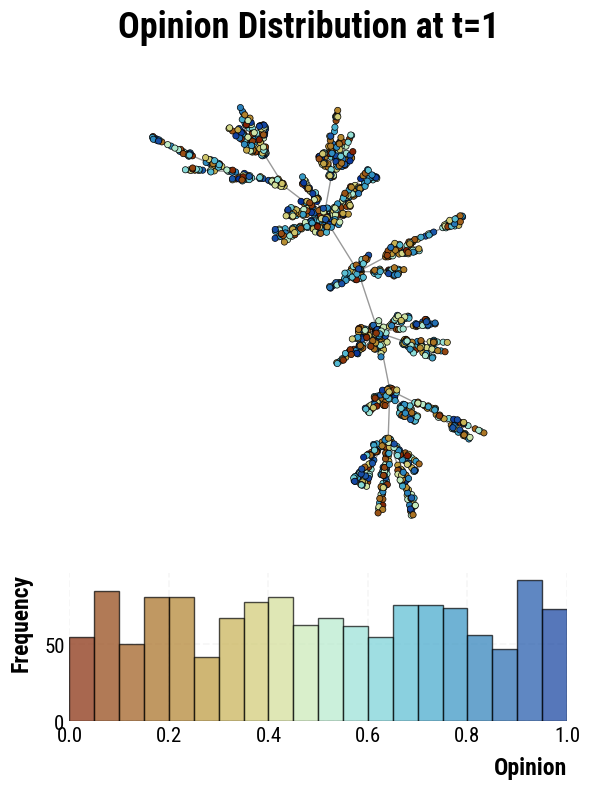

 14%|█▍        | 575/4001 [00:43<00:42, 81.53it/s] 

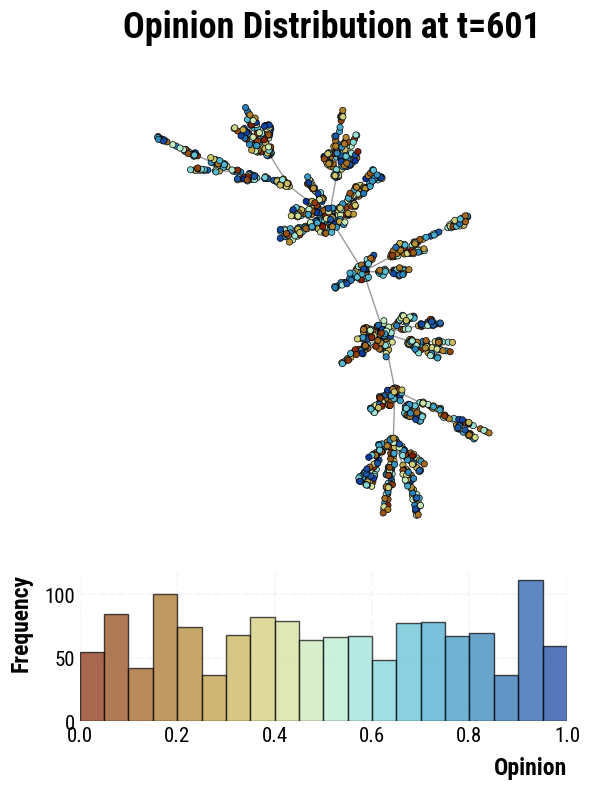

 28%|██▊       | 1137/4001 [00:44<00:05, 489.27it/s]

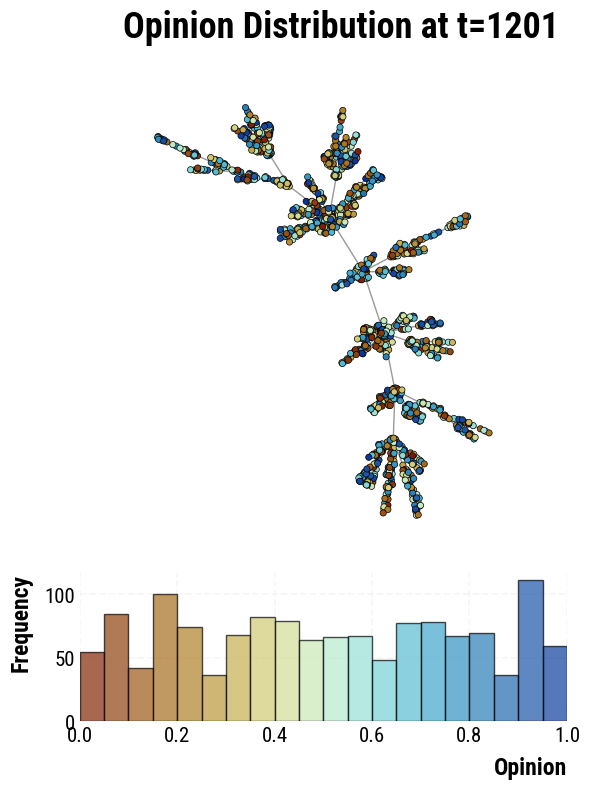

 45%|████▍     | 1782/4001 [00:45<00:03, 693.76it/s]

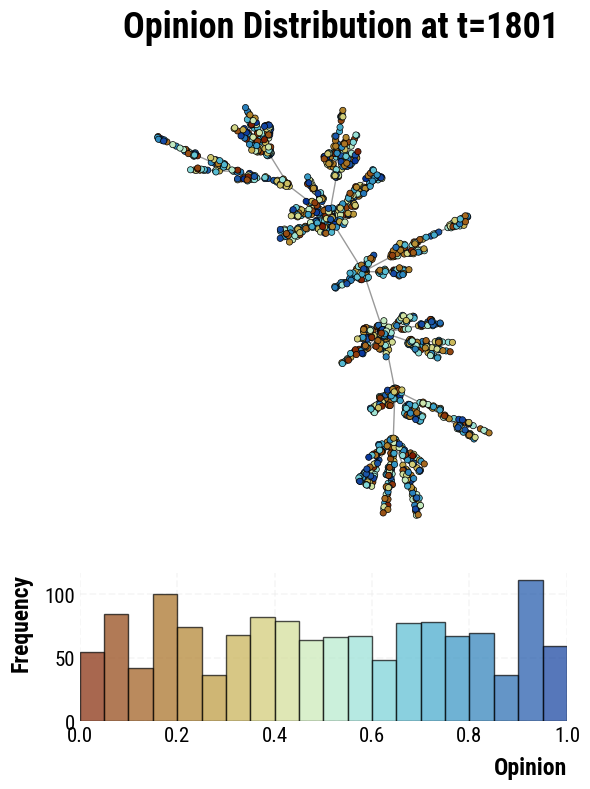

 59%|█████▉    | 2359/4001 [00:46<00:02, 701.85it/s]

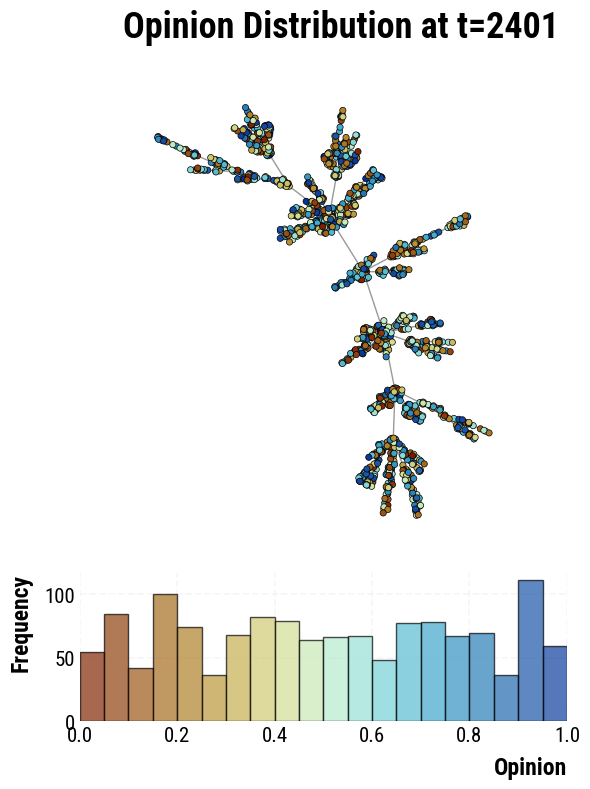

 73%|███████▎  | 2931/4001 [00:47<00:01, 698.07it/s]

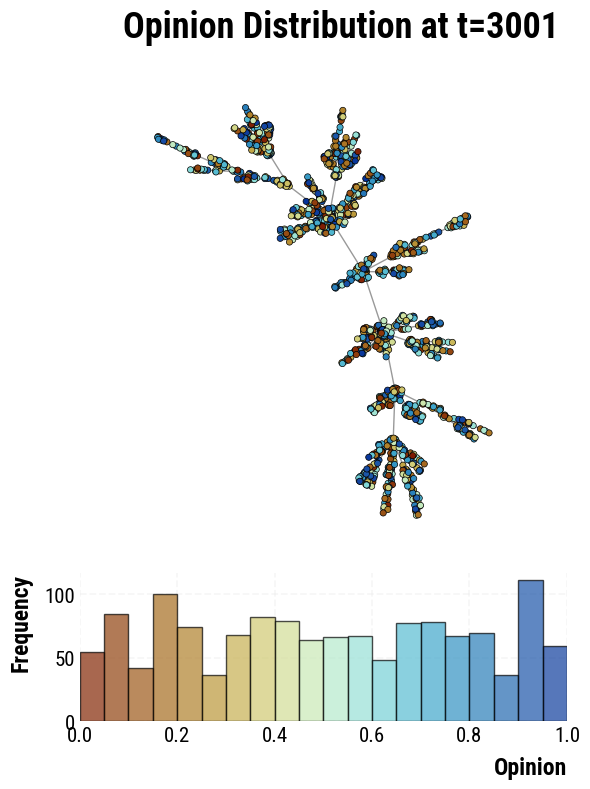

 89%|████████▉ | 3555/4001 [00:48<00:00, 677.74it/s]

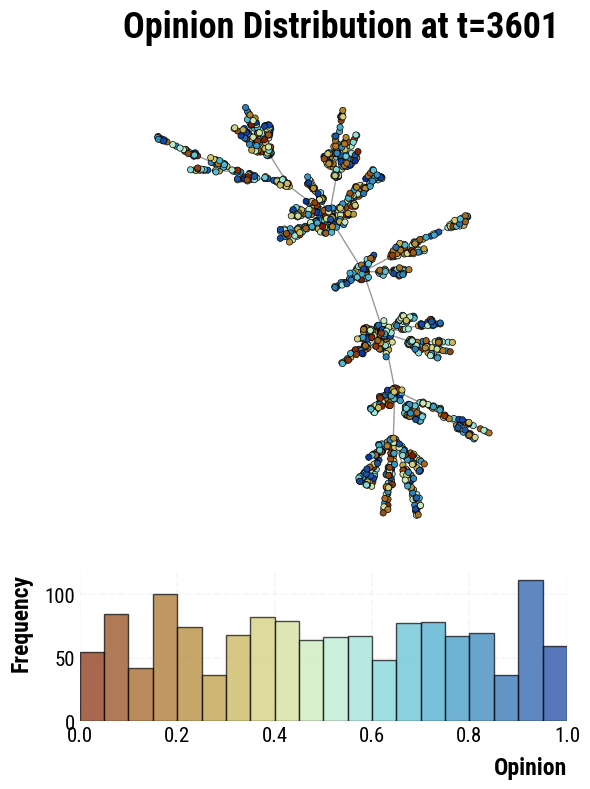

100%|██████████| 4001/4001 [00:48<00:00, 81.84it/s] 


In [67]:
model = HKModel(nx.barabasi_albert_graph(len(G_giant_component.nodes()), 1),
                epsilon=0.1, seed=None)  # tweak epsilon as you like
total_steps = 4000
every = 600
for t in tqdm.tqdm(range(0, total_steps + 1)):
    model.step()
    if t % every == 0:
        model.plot(title=f"t = {t}", cmap=colormaps.roma)


And now, lets compare this to the dynamics of our real network. Clearly, network-structure matters!

  0%|          | 0/2001 [00:00<?, ?it/s]

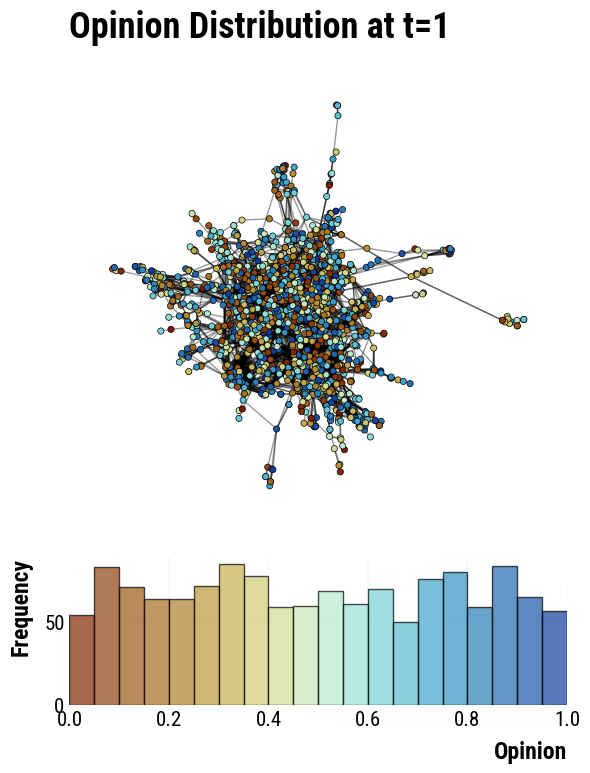

 14%|█▍        | 285/2001 [00:00<00:05, 342.18it/s]

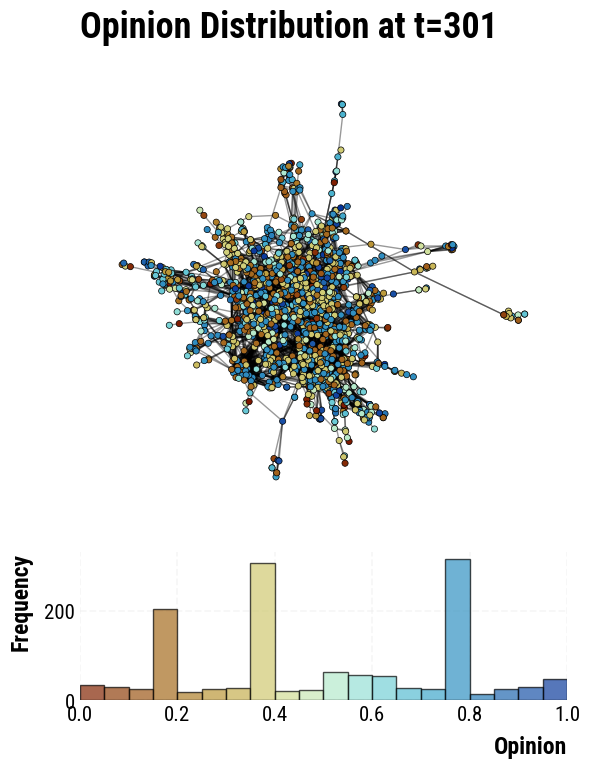

 30%|██▉       | 596/2001 [00:02<00:04, 319.35it/s]

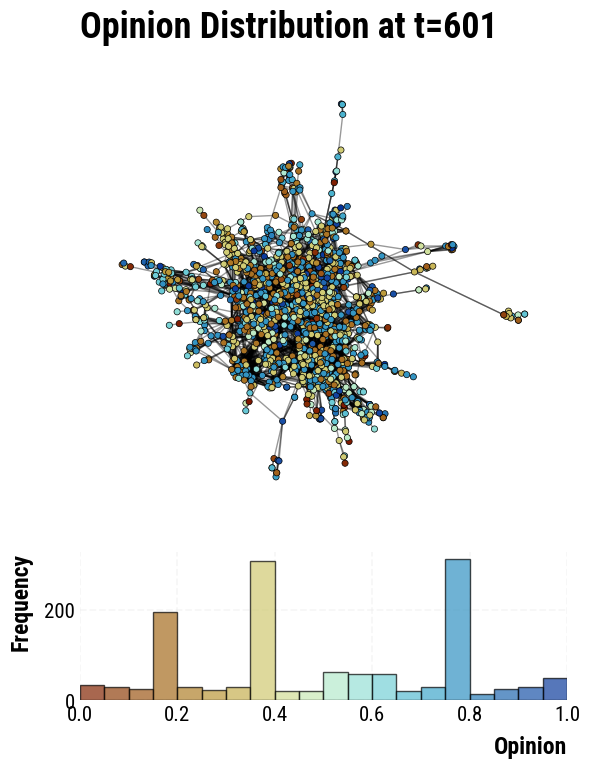

 44%|████▍     | 876/2001 [00:03<00:03, 333.44it/s]

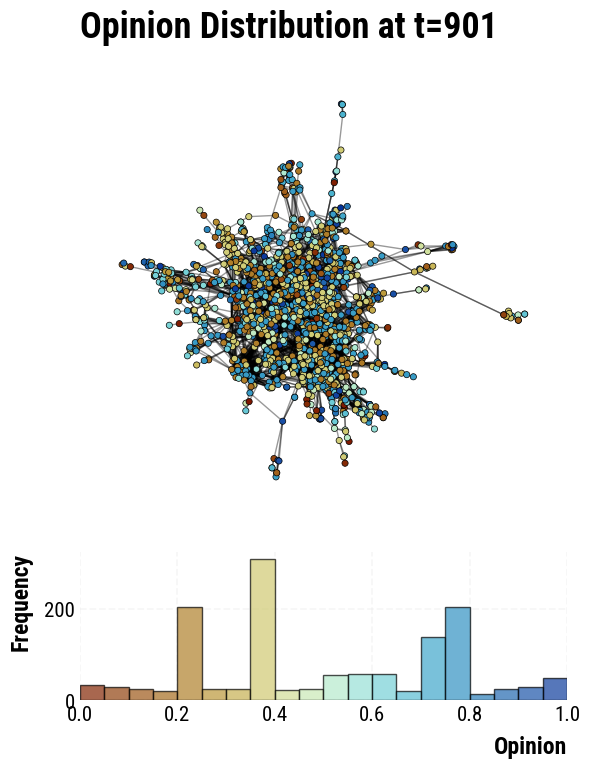

 59%|█████▉    | 1188/2001 [00:04<00:02, 335.58it/s]

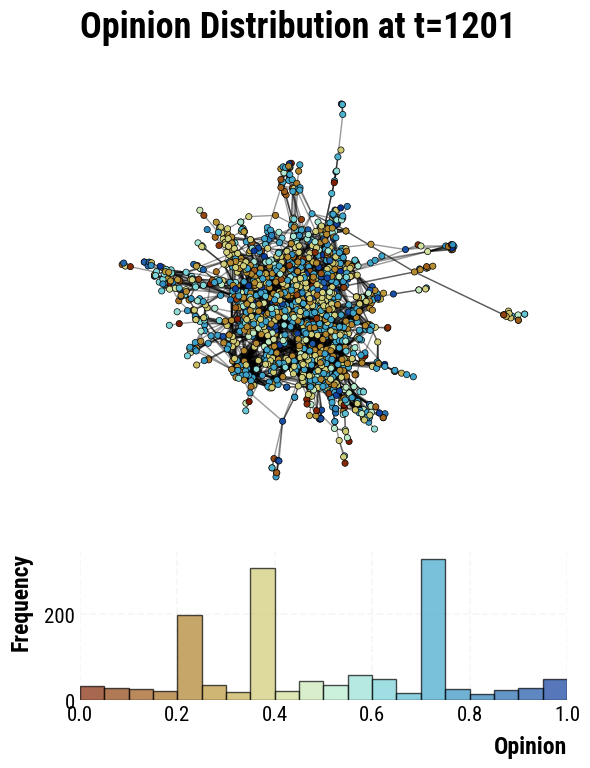

 75%|███████▍  | 1495/2001 [00:05<00:01, 326.21it/s]

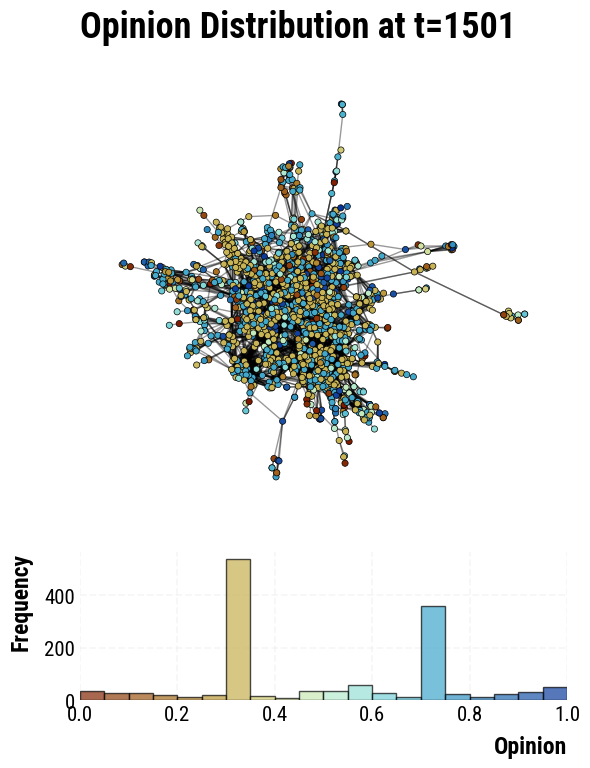

 90%|████████▉ | 1797/2001 [00:06<00:00, 326.22it/s]

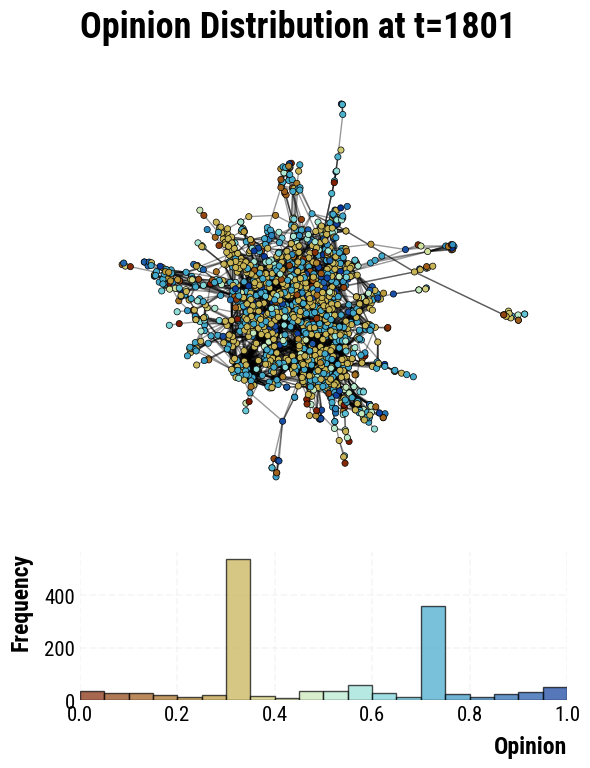

100%|██████████| 2001/2001 [00:07<00:00, 279.56it/s]


In [69]:
model = HKModel(G_giant_component, epsilon=0.1, seed=None) 

total_steps = 2000
every = 300
for t in tqdm.tqdm(range(0, total_steps + 1)):
    model.step()
    if t % every == 0:
        model.plot(title=f"t = {t}", cmap=colormaps.roma)
